In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [2]:
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True

In [3]:
class VAE(nn.Module):
    def __init__(self, ngf=64, ndf=64, nc=1, nz=50):
        super(VAE, self).__init__()
        self.nz = nz

        self.encoder = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(1024, 2 * nz),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc21 = nn.Linear(512, nz)
        self.fc22 = nn.Linear(512, nz)

        self.decoder = nn.Sequential(
            nn.Linear(nz, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Unflatten(1, (1024, 1, 1)),
            nn.ConvTranspose2d(1024, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )
        self.fc1 = nn.Linear(1024, 512)
        self.fc21 = nn.Linear(512, nz)
        self.fc22 = nn.Linear(512, nz)

        self.fc3 = nn.Linear(nz, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu_logvar = self.encoder(x).view(-1, 2, self.nz)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        
        z = self.reparameterize(mu, logvar)
        
        return self.decoder(z), mu, logvar

In [ ]:
# Linear
# class VAE(nn.Module):
#     def __init__(self, e_hidden=400, d_hidden=400, latent_dim=20):
#         super(VAE, self).__init__()
        
#         self.e_input2hidden = nn.Linear(in_features=784, out_features=e_hidden)
#         self.e_hidden2mean = nn.Linear(in_features=e_hidden, out_features=latent_dim)
#         self.e_hidden2logvar = nn.Linear(in_features=e_hidden, out_features=latent_dim)
        
#         self.d_latent2hidden = nn.Linear(in_features=latent_dim, out_features=d_hidden)
#         self.d_hidden2image = nn.Linear(in_features=d_hidden, out_features=784)
        
#     def encoder(self, x):
#         x = x.view(-1, 784)
#         x = F.relu(self.e_input2hidden(x))
#         return self.e_hidden2mean(x), self.e_hidden2logvar(x)
        
#     def decoder(self, z):
#         return torch.sigmoid(self.d_hidden2image(torch.relu(self.d_latent2hidden(z))))
        
#     def forward(self, x):
#         mu, logvar = self.encoder(x)
#         if self.training:
#             std = torch.exp(0.5 * logvar)
#             eps = torch.randn_like(std)
#             z = mu + eps * std
#         else:
#             z = mu
#         return self.decoder(z), mu, logvar

In [3]:
# Convolution (loss為負)
# class VAE(nn.Module):
#     def __init__(self, e_hidden=400, d_hidden=400, latent_dim=20):
#         super(VAE, self).__init__()
#         self.latent_dim = latent_dim

#         self.encoder = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(in_features=16*7*7, out_features=latent_dim * 2)
#         )
        
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=latent_dim, out_features=16*7*7),
#             nn.ReLU(),
#             nn.Unflatten(1, (16, 7, 7)),
#             nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.Sigmoid()
#         )
        
#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, x):
#         mu_logvar = self.encoder(x).view(-1, 2, self.latent_dim)
#         mu = mu_logvar[:, 0, :]
#         logvar = mu_logvar[:, 1, :]
        
#         z = self.reparameterize(mu, logvar)
        
#         return self.decoder(z), mu, logvar

In [4]:
def vae_loss(recon_x, x, mu, logvar):
    recon_x = recon_x.view(-1, 784)
    x = x.view(-1, 784)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [5]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = VAE().to(device)
model = VAE(ngf=64, ndf=64, nc=1, nz=50).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    average_loss = train_loss / len(train_loader.dataset)
    return average_loss

In [8]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            test_loss += vae_loss(recon, data, mu, logvar).item()
    average_loss = test_loss / len(test_loader.dataset)
    return average_loss

In [15]:
train_losses = []
test_losses = []
best_loss = float('inf')
epochs = 100
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer)
    test_loss = test(model, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'Epoch: {epoch}, Training Loss: {train_loss}, Test Loss: {test_loss}')
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), './vae_save/VAE_weights.pth')
        print(f'New best model saved with loss {best_loss}')

Epoch: 1, Training Loss: 149.1267377400716, Test Loss: 115.8370189086914
New best model saved with loss 115.8370189086914
Epoch: 2, Training Loss: 111.31558292236328, Test Loss: 106.60074790039063
New best model saved with loss 106.60074790039063
Epoch: 3, Training Loss: 105.83378963623046, Test Loss: 102.83720461425781
New best model saved with loss 102.83720461425781
Epoch: 4, Training Loss: 103.43696265055338, Test Loss: 101.55166535644531
New best model saved with loss 101.55166535644531
Epoch: 5, Training Loss: 101.61601310628255, Test Loss: 100.00719031982422
New best model saved with loss 100.00719031982422
Epoch: 6, Training Loss: 100.39913986002604, Test Loss: 98.79155568847656
New best model saved with loss 98.79155568847656
Epoch: 7, Training Loss: 99.28111604410807, Test Loss: 98.00458166503907
New best model saved with loss 98.00458166503907
Epoch: 8, Training Loss: 98.45089216715495, Test Loss: 98.31252924804687
Epoch: 9, Training Loss: 97.62471648763021, Test Loss: 97.35

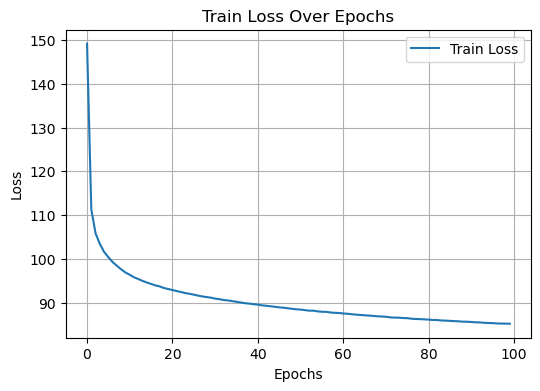

In [16]:
%matplotlib inline

plt.figure(figsize=(6, 4))

plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid()
plt.savefig('./vae_save/VAE_loss_new.png')
plt.show()

In [11]:
model.load_state_dict(torch.load('./vae_save/VAE_weights_new.pth'))

<All keys matched successfully>

In [13]:
def slerp(val, low, high):
    if isinstance(low, torch.Tensor):
        low = low.cpu().numpy()
    if isinstance(high, torch.Tensor):
        high = high.cpu().numpy()
    low = low.flatten()
    high = high.flatten()

    omega = np.arccos(np.clip(np.dot(low / np.linalg.norm(low), high / np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return (1.0 - val) * low + val * high
    return np.sin((1.0 - val) * omega) / so * low + np.sin(val * omega) / so * high

In [14]:
def interpolate_and_generate(model, data, n=8, use_slerp=False):
    fig, ax = plt.subplots(figsize=(10, 10))
    w = 28
    img = np.zeros((n * w, n * w))

    indices = []
    labels = []
    while len(indices) < 4:
        idx = torch.randint(len(data), (1,)).item()
        label = data[idx][1]
        if label not in labels:
            indices.append(idx)
            labels.append(label)
    images = [data[i][0].unsqueeze(0) for i in indices]
    
    model.eval()
    with torch.no_grad():
        latents = [model.encoder(images[i].to(device)).view(-1, model.nz * 2)[:,:model.nz] for i in range(len(images))]

    for i, row_latent in enumerate(np.linspace(0, 1, n)):
        for j, col_latent in enumerate(np.linspace(0, 1, n)):
            if use_slerp:
                z1 = slerp(row_latent, latents[0], latents[1])
                z2 = slerp(row_latent, latents[2], latents[3])
                latent = slerp(col_latent, z1, z2)
            else:
                latent = (1 - row_latent) * (1 - col_latent) * latents[0] + \
                         row_latent * (1 - col_latent) * latents[1] + \
                         (1 - row_latent) * col_latent * latents[2] + \
                         row_latent * col_latent * latents[3]
            latent = torch.from_numpy(latent).float().to(device)
            x_hat = model.decoder(latent.unsqueeze(0))
            img_idx = (n - 1 - i) * w, j * w
            img[img_idx[0]:(img_idx[0] + w), img_idx[1]:(img_idx[1] + w)] = x_hat.view(28, 28).cpu().detach().numpy()

    ax.imshow(img, cmap='gray')
    ticks = np.arange(0, n * w, 50)
    tick_labels = [str(i) for i in ticks]
    plt.xticks(ticks, labels=tick_labels)
    plt.yticks(ticks, labels=tick_labels)
    ax.set_axis_on()
    plt.savefig('./vae_save/VAE_results_new.png', bbox_inches='tight', pad_inches=0)
    plt.show()

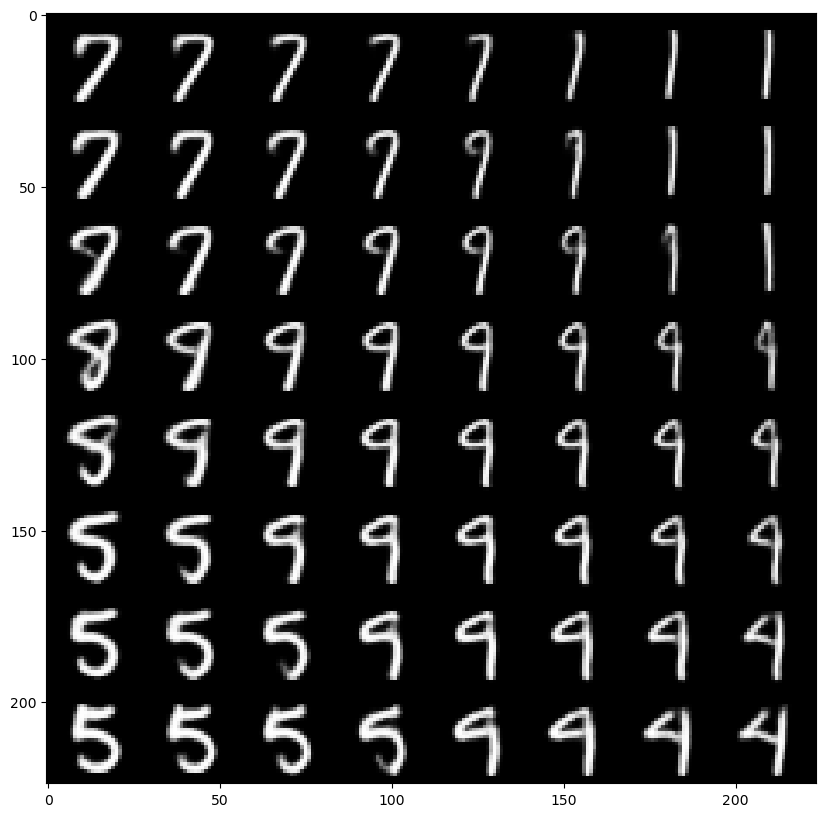

In [42]:
interpolate_and_generate(model, test_dataset, n=8, use_slerp=True)

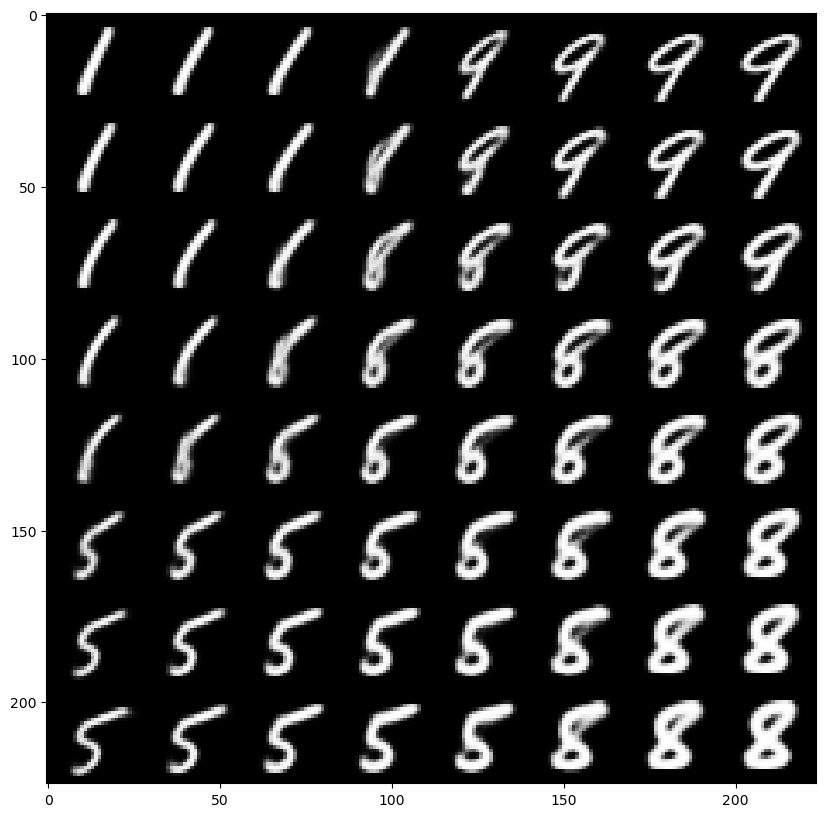

In [39]:
interpolate_and_generate(model, test_dataset, n=8, use_slerp=True)